# Data Analysis Drugs 288 Up

In [159]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle
import re
from io import StringIO
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import tarfile

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

In [160]:
wd = os.getcwd()
wd

path = os.path.join(os.path.join(wd, "data"), "start_288")
path
path1 = os.path.join(os.path.join(wd, "data"), "TSV_LOG")

In [161]:
for d in os.listdir(path):
    folder = os.path.join(path, d)
    if os.path.isdir(folder):
        # print("fdjajflas")
        # curr = os.path.join(folder, d)
        
        for f in tqdm.tqdm(os.listdir(folder), desc=f"{folder}"):
            sub_dir = os.path.join(folder, f)
            # print(sub_dir)
            if os.path.isdir(sub_dir):
                # print(sub_dir)
                
                for t in os.listdir(sub_dir):

                    file = os.path.join(sub_dir, t)
                    if not os.path.isdir(file) and tarfile.is_tarfile(file):
                        # print(file)
                        # print(sub_dir)
                        tf = tarfile.open(file)
                        tf.extractall(sub_dir)
                        tf.close()

/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9010146.amn-0001: 100%|██████████| 42/42 [00:10<00:00,  3.95it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009232.amn-0001: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009266.amn-0001: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009313.amn-0001: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009646.amn-0001: 100%|██████████| 41/41 [00:10<00:00,  3.97it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009183.amn-0001: 100%|██████████| 42/42 [00:10<00:00,  3.88it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009628.amn-0001: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]
/Users/jakegwinn/Documents/argonne_all/argonne/data/start_288/9009458.amn-0001: 100%|██████████| 40/40 [

## Functions

In [162]:
def get_data_ALL(path, wanted_jobs):
    """Get all drug data into one dictionary from all specified jobs

    Args:
        path (string): path to list of tsv's
        wanted_jobs (list): list of jobs to look through

    Returns:
        dictonary: dictionary indexed by drug name
    """
    # wanted_jobs = os.listdir(path)
    drugs_perf = {}

    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
                # if job in wanted_jobs:    
                #     for model in tqdm.tqdm(os.listdir(curr), desc=f"{job}"):
                #         inner = os.path.join(curr, model)
                        
                #         for subdir, dirs, files in os.walk(inner):
                #             for file in files:
                                # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        # print(df.columns)
                        
                        drug = df["Drug1"][0]
                        # print(drug)
                        if drug not in drugs_perf:
                            drugs_perf[drug] = []
                            drugs_perf[drug].append(df)
                        else:
                            drugs_perf[drug].append(df)
                            

    drug_dict = {}
    for key, value in tqdm.tqdm(drugs_perf.items()):
        drug_dict[key] = pd.concat(value)
        
        
    return drug_dict

In [163]:
def get_all_drug_dfs(drg, path, wanted_jobs):
    """gets drug dfs and locations of given drug

    Args:
        drg (string): specific drug wanted
        path (string): path to list of TSV's
        wanted_jobs (list): list of jobs to search through

    Returns:
        two lists: list of dfs and list of drug locations
    """
    
    drug_loc = []
    
    # Iterate over every job in the directory 
    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
        
        
        # for job in os.listdir(path):
        #     curr = os.path.join(path, job)
            
        #     # Check if current job is in the wanted_jobs list 
        #     if job in wanted_jobs:
        #         print(f"----------{job}----------")
        #         samples_rmse_curr = {}
                
        #         # Iterates over every model in the job
        #         for model in tqdm.tqdm(os.listdir(curr)):
        #             inner = os.path.join(curr, model)
                    
        #             # Iterates over every file within the model 
        #             for subdir, dirs, files in os.walk(inner):
        #                 for file in files:
                            
                            # Creates dataframe
                        # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        
                        # Gets drug
                        drug = df["Drug1"][0]
                        # print(drug)
                        fold_num = fold
                        number = num
                        # Checks to see if drug is the same as wanted drug
                        if drg == drug:
                            drug_loc.append((job, fold_num, number))

    dfs = []
    locs = []
    
    # Iterates over all the found locations of the drg TSVs
    for j,folder, number in drug_loc:
        
        file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(path, j), folder), j), number), "predicted.tsv")

        # Make a dataframe and include a new column with what job it is from
        df = pd.read_csv(file, sep="\t")
        df["Job"] = j
        
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

In [164]:
def make_distrib_plot(drg, d_dict):
    
    # Get dataframe for specified drug
    drug_df = d_dict[drg]
    
    # Plot Distribution 
    fig, ax1 = plt.subplots()
    
    drug_df["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
    drug_df["AUCError"].plot.hist(ax=ax1,
                            density = True, 
                            bins=30, 
                            rwidth = 0.9)

    ax1.set_title(f"Distribution of AUC Errors of {drg}\nAll Specified Jobs")
    ax1.set_ylabel("")
    ax1.set_xlabel("AUC Error")

In [165]:
def make_multiplot(drg, path, wanted_jobs):
    
    drug_dfs, drug_jobs = get_all_drug_dfs(drg=drg, path=path, wanted_jobs=wanted_jobs)
    
    # print(drug_dfs)
    
    # Get grid layout
    N = len(drug_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    print(f"TOTAL: {N}-----({x, y})")
    
    # Make Subplots
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {drg} over all Individual Jobs")
    
    k = 0
    j = 0

    # Iterate over all subplots and plot each distribution for every specified job
    for i, d in enumerate(drug_dfs):
        # print(f"####### {(k,j)} #######")
        # print(d["AUCError"])

        k = int(k)
        j = int(j)
        d["AUCError"].plot.kde(ax=ax1[k][j] )
        d["AUCError"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))

        ax1[k][j].set_title(f"{drug_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC Error", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

In [166]:
def boostraped_rmse(df, B): 
    """Create Bootsrtap sample of a statistic

    Args:
        x (num): values you want infrence from 
        B (in): Number of bootstrap samples
        statsFun (fun): metric you want infrence on 
    """
    x_auc = df["AUC"]
    x_pred_auc = df["PredictedAUC"]
    x_auc = np.array(x_auc)
    x_pred_auc = np.array(x_pred_auc)
    
    resampled_stat = []
    
    for b in tqdm.tqdm(range(B)):
        index = np.random.randint(0, len(x_auc), len(x_auc))
        sample_auc = x_auc[index]
        sample_pred_auc = x_pred_auc[index]
        
        bstatistic = mean_squared_error(sample_auc, sample_pred_auc, squared=False)
        resampled_stat.append(bstatistic)
        
    return np.array(resampled_stat)

## EDA

### Look for Epoch Differences

In [167]:
key_list = ["Job", "Folder", "Num", "drug", "epochs_wanted", "actual_epochs"]
data = {key: [] for key in key_list}

for j in os.listdir(path):
    # print(f"-------------{j}-------------")
    j_path = os.path.join(path, j)
    for fold in os.listdir(j_path):
        fold_path = os.path.join(j_path, fold)
        
        if os.path.isdir(fold_path):
        
            inner_most = os.path.join(fold_path, j) 
            # print(f"###{fold}####")
            for num in os.listdir(inner_most):
                num_path = os.path.join(inner_most, num)
                tsv_file = os.path.join(num_path, "predicted.tsv")
                log_file = os.path.join(num_path, "python.log")
                
                if os.path.exists(tsv_file):
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    drug = df["Drug1"][0]
                    
                    data["Job"].append(j)
                    data["Folder"].append(fold)
                    data["drug"].append(drug)
                    data["Num"].append(num)
                    prev_epoch_hist_length = len(data["actual_epochs"])
                    log_data = open(log_file, 'r')
                    # data["path"].append(tsv_file)
                    for line in log_data:

                        # Get specified epochs
                        matches_wanted = re.findall("'epochs': \d+", line)
                        
                        # get how many epochs it actually ran for
                        matches_history = re.findall("history_length: \d+", line)

                        if matches_wanted:
                            data["epochs_wanted"].append(matches_wanted[0][-2:]) 
                            # print(matches_wanted[0])
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")

                        if matches_history:
                            data["actual_epochs"].append(matches_history[0][-2:])
                            # print(matches_history[0])
                            
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")
                    # if len(data["actual_epochs"]) == prev_epoch_hist_length:
                    #     print(f"{j}: {num}")
                    #     print(log_file)
                    #     print("fdjhfajkhfjbhbhjgbhjghjgjgjhgjhgjhguhuivibkdhajahk")
                else:
                    print(f"{j}/{fold}/{j}/{num}")
                    
                # prev_epoch_hist_length = len(data["actual_epochs"])
    

In [168]:
df = pd.DataFrame(data)
df[["epochs_wanted", "actual_epochs"]] = df[["epochs_wanted", "actual_epochs"]].apply(pd.to_numeric)

In [169]:
df = (df.assign(
        epoch_diff =df["epochs_wanted"] - df["actual_epochs"]
    )
)
# print(len(df.index))
print(df.sort_values(["epochs_wanted", "actual_epochs"], ascending=[False, True]).to_string())

                   Job         Folder  Num       drug  epochs_wanted  actual_epochs  epoch_diff
502   9009232.amn-0001  x1921c3s4b0n0  225  Drug_1044             50             27          23
2400  9009183.amn-0001  x1921c5s1b0n0  307  Drug_1482             50             27          23
661   9009232.amn-0001  x1921c6s2b0n0  390  Drug_1210             50             28          22
1190  9009266.amn-0001  x1921c6s0b0n0  363  Drug_1175             50             28          22
1236  9009266.amn-0001  x1921c6s4b0n0  413    Drug_47             50             28          22
2230  9009646.amn-0001  x1921c2s3b0n0  114   Drug_664             50             28          22
4388  9009154.amn-0001  x1921c4s6b0n0   46   Drug_383             50             28          22
27    9010146.amn-0001  x1922c0s7b0n0  105  Drug_1053             50             29          21
202   9010146.amn-0001  x1922c0s0b0n0   24   Drug_386             50             29          21
212   9010146.amn-0001  x1921c7s6b0n0   

### Looking for Worst Drugs in each Job

In [170]:
drug_dict = get_data_ALL(path=path, wanted_jobs=os.listdir(path))

100%|██████████| 456/456 [00:00<00:00, 1480.15it/s]


In [171]:
key_list = ["Drug", "RMSE", "n"]
drugs_rmse = {key: [] for key in key_list}


for key, value in drug_dict.items(): 
    drugs_rmse["Drug"].append(key)
    curr_rmse = mean_squared_error(value["AUC"], value["PredictedAUC"], squared=False)
    drugs_rmse["RMSE"].append(curr_rmse)
    drugs_rmse["n"].append(len(value))

In [172]:
all_drugs_df_n = pd.DataFrame(drugs_rmse).sort_values(["n"], ascending=False)
all_drugs_df_rmse = pd.DataFrame(drugs_rmse).sort_values(["RMSE"], ascending=False)
bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]
all_drugs_df_rmse.head(50)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_599/1766996581.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]


,Drug,RMSE,n
396,Drug_1078,0.472222,17770
422,Drug_118,0.413904,6910
131,Drug_718,0.407259,5580
273,Drug_1305,0.393454,5760
1,Drug_156,0.371690,4914
129,Drug_1186,0.361857,6930
445,Drug_1472,0.347259,9710
290,Drug_755,0.338794,8530
395,Drug_593,0.323242,6363
306,Drug_377,0.311436,2240


Text(0.5, 1.0, 'Distribution of Drug RMSEs')

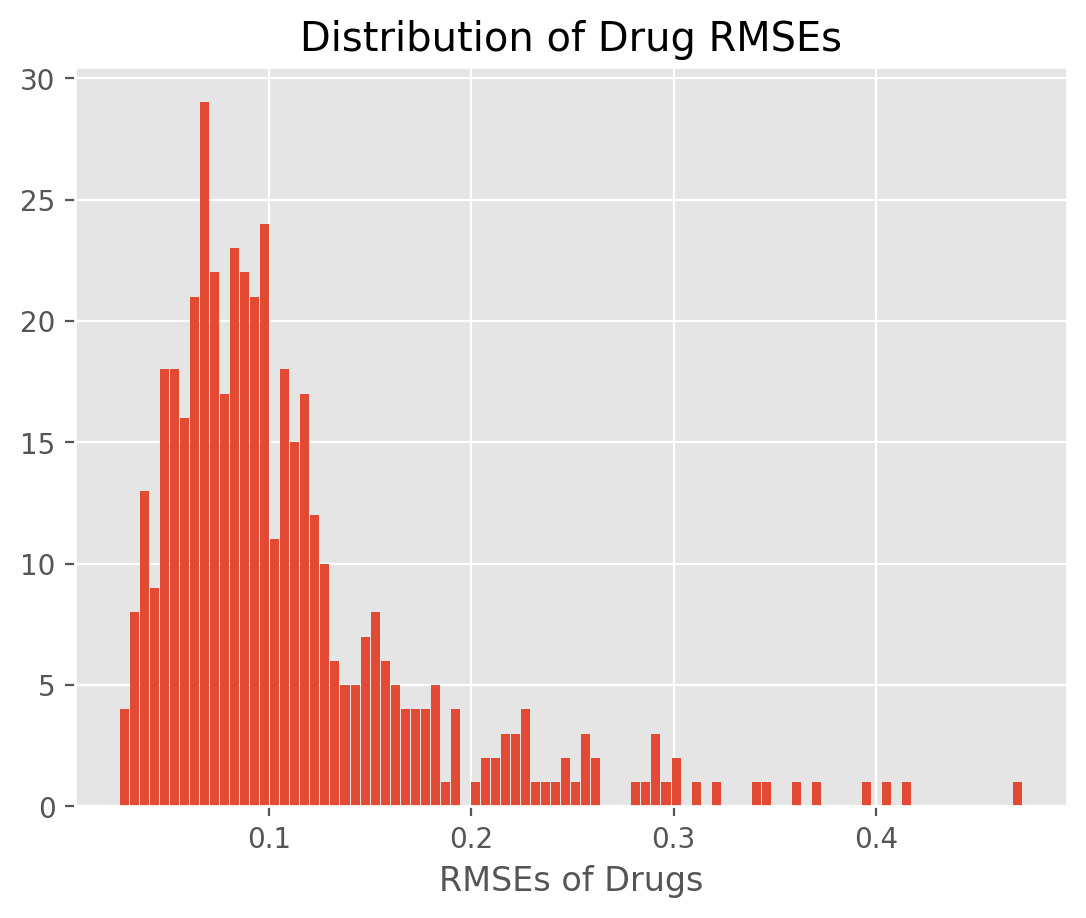

In [173]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["RMSE"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"RMSEs of Drugs")
ax1.set_title("Distribution of Drug RMSEs")

In [174]:
drugs_perf = {}

jobs = []

rmse_jobs = []
worst_drugs = []
rmse_jobs = []
all_locations = []

for job in os.listdir(path):
    j_path = os.path.join(path, job)
    
    rmses_curr = {}
    
    jobs.append(job)
    
    if job in os.listdir(path):
    
        for fold in os.listdir(j_path):
            
            fold_path = os.path.join(j_path, fold)
            
            if os.path.isdir(fold_path):
            
                inner_most = os.path.join(fold_path, job) 
                # print(f"###{fold}####")
                for num in os.listdir(inner_most):
                    num_path = os.path.join(inner_most, num)
                    tsv_file = os.path.join(num_path, "predicted.tsv")
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    # Getting folder locatio and which drug it is 
                    fold_num = num
                    drug = df["Drug1"][0]
                    
                    rmse = mean_squared_error(df["AUC"], df["PredictedAUC"], squared=False)
                    
                    # print(num, drug)
                    
                    key = (drug, fold_num)
                    rmses_curr[(key)] = rmse
                    # print(rmses_curr)
        worst_drug = max(rmses_curr, key = rmses_curr.get)      
        worst_drug_rmse = rmses_curr[worst_drug]
        print(worst_drug, worst_drug_rmse)
        
        worst_drugs.append(worst_drug[0])
        rmse_jobs.append(worst_drug_rmse)
        all_locations.append(worst_drug[1])
        
bad_drugs = pd.DataFrame({"Job":jobs, "Folder":all_locations, "worst_drug":worst_drugs, "RMSE":rmse_jobs})
bad_drugs.sort_values("RMSE", ascending=False)

# Getting the frequency of each drug in the worst drug array
drugs, counts = np.unique(worst_drugs, return_counts=True)

('Drug_1078', '129') 0.4386975469738552
('Drug_718', '230') 0.4413033379177498
('Drug_1078', '129') 0.478624711045758
('Drug_1078', '129') 0.516860636636217
('Drug_718', '230') 0.4832248748166603
('Drug_1078', '129') 0.4889331647869548
('Drug_1078', '129') 0.47439444254028945
('Drug_1078', '129') 0.49931217281385204
('Drug_1078', '129') 0.46936885592785693
('Drug_1078', '129') 0.4679823028004198


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_599/1669054811.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(drugs, rotation = 45)


Text(0.5, 0.98, 'Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)')

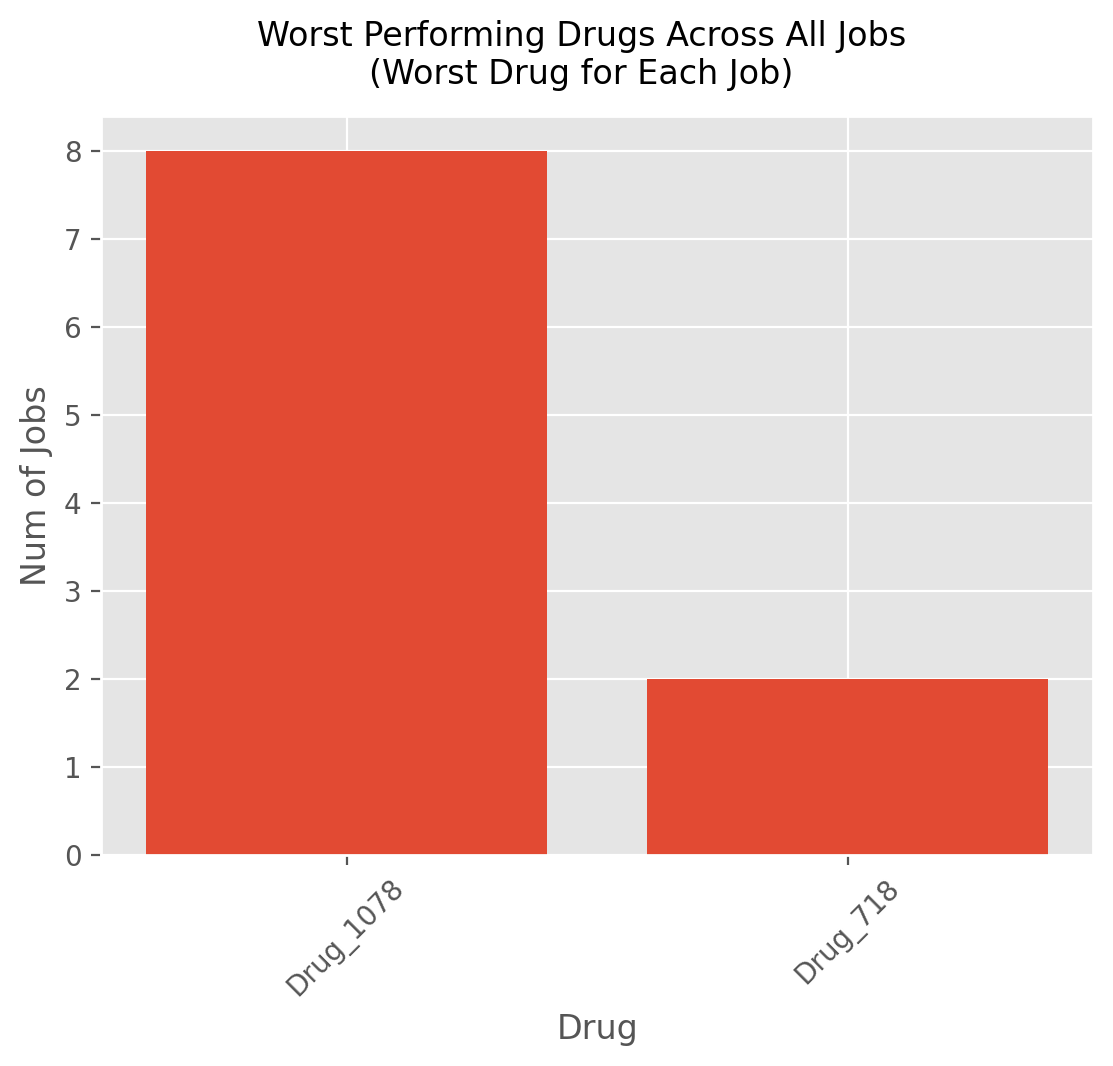

In [175]:
fig, ax = plt.subplots()

ax.bar(drugs, counts)

ax.set_xticklabels(drugs, rotation = 45)
ax.set_ylabel("Num of Jobs")
ax.set_xlabel("Drug")
fig.suptitle("Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)")

## Drug 1078 Investigation

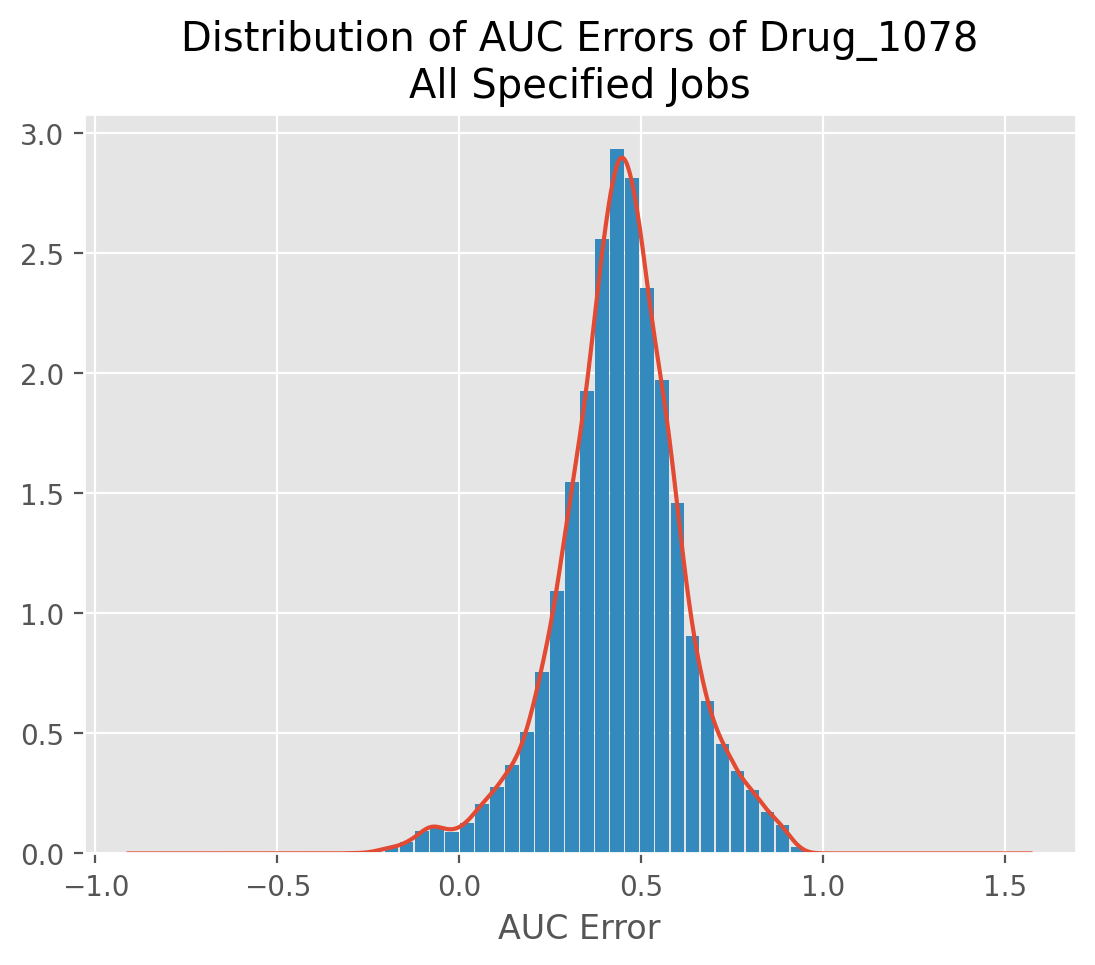

In [176]:
make_distrib_plot("Drug_1078", drug_dict)

In [177]:
for key in tqdm.tqdm(drug_dict.keys()):
     dfs, j= get_all_drug_dfs(key, path=path, wanted_jobs=os.listdir(path))
     print(f"Drug: {key}---dfs: {len(dfs)}")

  0%|          | 1/456 [00:03<30:01,  3.96s/it]

Drug: Drug_618---dfs: 9


  0%|          | 2/456 [00:07<30:14,  4.00s/it]

Drug: Drug_156---dfs: 9


  1%|          | 3/456 [00:11<30:00,  3.97s/it]

Drug: Drug_1175---dfs: 9


  1%|          | 4/456 [00:15<29:42,  3.94s/it]

Drug: Drug_120---dfs: 9


  1%|          | 5/456 [00:19<29:39,  3.95s/it]

Drug: Drug_551---dfs: 9


  1%|▏         | 6/456 [00:23<29:27,  3.93s/it]

Drug: Drug_542---dfs: 9


  2%|▏         | 7/456 [00:27<29:37,  3.96s/it]

Drug: Drug_1193---dfs: 9


  2%|▏         | 8/456 [00:31<29:37,  3.97s/it]

Drug: Drug_749---dfs: 9


  2%|▏         | 9/456 [00:35<29:33,  3.97s/it]

Drug: Drug_1306---dfs: 9


  2%|▏         | 10/456 [00:39<29:20,  3.95s/it]

Drug: Drug_239---dfs: 9


  2%|▏         | 11/456 [00:43<29:16,  3.95s/it]

Drug: Drug_1349---dfs: 9


  3%|▎         | 12/456 [00:47<29:04,  3.93s/it]

Drug: Drug_1137---dfs: 9


  3%|▎         | 13/456 [00:51<29:10,  3.95s/it]

Drug: Drug_1244---dfs: 10


  3%|▎         | 14/456 [00:55<29:00,  3.94s/it]

Drug: Drug_625---dfs: 10


  3%|▎         | 15/456 [00:59<28:55,  3.94s/it]

Drug: Drug_619---dfs: 10


  4%|▎         | 16/456 [01:03<28:47,  3.93s/it]

Drug: Drug_1449---dfs: 10


  4%|▎         | 17/456 [01:07<28:50,  3.94s/it]

Drug: Drug_438---dfs: 10


  4%|▍         | 18/456 [01:11<28:42,  3.93s/it]

Drug: Drug_933---dfs: 10


  4%|▍         | 19/456 [01:14<28:39,  3.94s/it]

Drug: Drug_1021---dfs: 10


  4%|▍         | 20/456 [01:19<29:06,  4.01s/it]

Drug: Drug_1521---dfs: 10


  5%|▍         | 21/456 [01:23<28:51,  3.98s/it]

Drug: Drug_919---dfs: 10


  5%|▍         | 22/456 [01:26<28:38,  3.96s/it]

Drug: Drug_159---dfs: 10


  5%|▌         | 23/456 [01:30<28:27,  3.94s/it]

Drug: Drug_1066---dfs: 10


  5%|▌         | 24/456 [01:34<28:22,  3.94s/it]

Drug: Drug_941---dfs: 10


  5%|▌         | 25/456 [01:38<28:14,  3.93s/it]

Drug: Drug_1474---dfs: 8


  6%|▌         | 26/456 [01:42<28:07,  3.93s/it]

Drug: Drug_687---dfs: 8


  6%|▌         | 27/456 [01:46<28:03,  3.92s/it]

Drug: Drug_983---dfs: 8


  6%|▌         | 28/456 [01:50<27:55,  3.92s/it]

Drug: Drug_1053---dfs: 8


  6%|▋         | 29/456 [01:54<27:52,  3.92s/it]

Drug: Drug_793---dfs: 8


  7%|▋         | 30/456 [01:58<27:45,  3.91s/it]

Drug: Drug_728---dfs: 8


  7%|▋         | 31/456 [02:02<27:41,  3.91s/it]

Drug: Drug_413---dfs: 8


  7%|▋         | 32/456 [02:06<27:42,  3.92s/it]

Drug: Drug_1274---dfs: 8


  7%|▋         | 33/456 [02:10<27:36,  3.92s/it]

Drug: Drug_34---dfs: 8


  7%|▋         | 34/456 [02:13<27:27,  3.90s/it]

Drug: Drug_255---dfs: 8


  8%|▊         | 35/456 [02:17<27:23,  3.90s/it]

Drug: Drug_558---dfs: 8


  8%|▊         | 36/456 [02:21<27:24,  3.91s/it]

Drug: Drug_1197---dfs: 8


  8%|▊         | 37/456 [02:25<27:21,  3.92s/it]

Drug: Drug_430---dfs: 10


  8%|▊         | 38/456 [02:29<27:15,  3.91s/it]

Drug: Drug_715---dfs: 10


  9%|▊         | 39/456 [02:33<27:13,  3.92s/it]

Drug: Drug_1556---dfs: 10


  9%|▉         | 40/456 [02:37<27:22,  3.95s/it]

Drug: Drug_215---dfs: 10


  9%|▉         | 41/456 [02:41<27:12,  3.93s/it]

Drug: Drug_333---dfs: 10


  9%|▉         | 42/456 [02:45<27:02,  3.92s/it]

Drug: Drug_1350---dfs: 10


  9%|▉         | 43/456 [02:49<26:58,  3.92s/it]

Drug: Drug_290---dfs: 10


 10%|▉         | 44/456 [02:53<26:50,  3.91s/it]

Drug: Drug_480---dfs: 10


 10%|▉         | 45/456 [02:57<26:45,  3.91s/it]

Drug: Drug_240---dfs: 10


 10%|█         | 46/456 [03:00<26:43,  3.91s/it]

Drug: Drug_1265---dfs: 10


 10%|█         | 47/456 [03:05<27:20,  4.01s/it]

Drug: Drug_1044---dfs: 10


 11%|█         | 48/456 [03:09<27:01,  3.97s/it]

Drug: Drug_982---dfs: 10


 11%|█         | 49/456 [03:13<28:07,  4.15s/it]

Drug: Drug_1310---dfs: 10


 11%|█         | 50/456 [03:17<27:31,  4.07s/it]

Drug: Drug_589---dfs: 10


 11%|█         | 51/456 [03:21<27:14,  4.04s/it]

Drug: Drug_788---dfs: 10


 11%|█▏        | 52/456 [03:25<26:52,  3.99s/it]

Drug: Drug_667---dfs: 10


 12%|█▏        | 53/456 [03:29<26:41,  3.97s/it]

Drug: Drug_227---dfs: 10


 12%|█▏        | 54/456 [03:33<26:26,  3.95s/it]

Drug: Drug_935---dfs: 10


 12%|█▏        | 55/456 [03:37<26:17,  3.93s/it]

Drug: Drug_943---dfs: 10


 12%|█▏        | 56/456 [03:40<26:07,  3.92s/it]

Drug: Drug_811---dfs: 10


 12%|█▎        | 57/456 [03:44<26:02,  3.92s/it]

Drug: Drug_1239---dfs: 10


 13%|█▎        | 58/456 [03:48<25:52,  3.90s/it]

Drug: Drug_785---dfs: 10


 13%|█▎        | 59/456 [03:52<25:50,  3.91s/it]

Drug: Drug_1562---dfs: 10


 13%|█▎        | 60/456 [03:56<25:43,  3.90s/it]

Drug: Drug_772---dfs: 10


 13%|█▎        | 61/456 [04:00<25:40,  3.90s/it]

Drug: Drug_676---dfs: 10


 14%|█▎        | 62/456 [04:04<25:33,  3.89s/it]

Drug: Drug_1421---dfs: 10


 14%|█▍        | 63/456 [04:08<25:31,  3.90s/it]

Drug: Drug_425---dfs: 10


 14%|█▍        | 64/456 [04:12<25:27,  3.90s/it]

Drug: Drug_821---dfs: 10


 14%|█▍        | 65/456 [04:16<25:29,  3.91s/it]

Drug: Drug_683---dfs: 10


 14%|█▍        | 66/456 [04:19<25:24,  3.91s/it]

Drug: Drug_802---dfs: 10


 15%|█▍        | 67/456 [04:23<25:23,  3.92s/it]

Drug: Drug_363---dfs: 10


 15%|█▍        | 68/456 [04:27<25:17,  3.91s/it]

Drug: Drug_1499---dfs: 10


 15%|█▌        | 69/456 [04:31<25:13,  3.91s/it]

Drug: Drug_565---dfs: 10


 15%|█▌        | 70/456 [04:35<25:05,  3.90s/it]

Drug: Drug_419---dfs: 10


 16%|█▌        | 71/456 [04:39<25:03,  3.90s/it]

Drug: Drug_783---dfs: 10


 16%|█▌        | 72/456 [04:43<24:58,  3.90s/it]

Drug: Drug_602---dfs: 10


 16%|█▌        | 73/456 [04:47<24:59,  3.92s/it]

Drug: Drug_235---dfs: 9


 16%|█▌        | 74/456 [04:51<24:52,  3.91s/it]

Drug: Drug_230---dfs: 9


 16%|█▋        | 75/456 [04:55<24:48,  3.91s/it]

Drug: Drug_630---dfs: 9


 17%|█▋        | 76/456 [04:59<25:00,  3.95s/it]

Drug: Drug_876---dfs: 9


 17%|█▋        | 77/456 [05:03<24:49,  3.93s/it]

Drug: Drug_1156---dfs: 9


 17%|█▋        | 78/456 [05:06<24:44,  3.93s/it]

Drug: Drug_730---dfs: 9


 17%|█▋        | 79/456 [05:10<24:35,  3.91s/it]

Drug: Drug_36---dfs: 9


 18%|█▊        | 80/456 [05:14<24:31,  3.91s/it]

Drug: Drug_1241---dfs: 9


 18%|█▊        | 81/456 [05:18<24:33,  3.93s/it]

Drug: Drug_1035---dfs: 9


 18%|█▊        | 82/456 [05:22<24:33,  3.94s/it]

Drug: Drug_361---dfs: 9


 18%|█▊        | 83/456 [05:26<24:24,  3.93s/it]

Drug: Drug_329---dfs: 9


 18%|█▊        | 84/456 [05:30<24:21,  3.93s/it]

Drug: Drug_186---dfs: 9


 19%|█▊        | 85/456 [05:34<24:12,  3.92s/it]

Drug: Drug_183---dfs: 10


 19%|█▉        | 86/456 [05:38<24:10,  3.92s/it]

Drug: Drug_409---dfs: 10


 19%|█▉        | 87/456 [05:42<24:02,  3.91s/it]

Drug: Drug_411---dfs: 10


 19%|█▉        | 88/456 [05:46<24:04,  3.93s/it]

Drug: Drug_1381---dfs: 10


 20%|█▉        | 89/456 [05:50<23:58,  3.92s/it]

Drug: Drug_315---dfs: 10


 20%|█▉        | 90/456 [05:54<23:59,  3.93s/it]

Drug: Drug_532---dfs: 10


 20%|█▉        | 91/456 [05:57<23:54,  3.93s/it]

Drug: Drug_1146---dfs: 10


 20%|██        | 92/456 [06:01<23:51,  3.93s/it]

Drug: Drug_897---dfs: 10


 20%|██        | 93/456 [06:05<23:42,  3.92s/it]

Drug: Drug_391---dfs: 10


 21%|██        | 94/456 [06:09<23:38,  3.92s/it]

Drug: Drug_32---dfs: 10


 21%|██        | 95/456 [06:13<24:04,  4.00s/it]

Drug: Drug_517---dfs: 10


 21%|██        | 96/456 [06:17<23:54,  3.98s/it]

Drug: Drug_1490---dfs: 10


 21%|██▏       | 97/456 [06:21<23:46,  3.97s/it]

Drug: Drug_256---dfs: 10


 21%|██▏       | 98/456 [06:25<23:49,  3.99s/it]

Drug: Drug_1098---dfs: 10


 22%|██▏       | 99/456 [06:29<23:42,  3.98s/it]

Drug: Drug_105---dfs: 10


 22%|██▏       | 100/456 [06:33<23:33,  3.97s/it]

Drug: Drug_615---dfs: 10


 22%|██▏       | 101/456 [06:37<23:20,  3.94s/it]

Drug: Drug_465---dfs: 10


 22%|██▏       | 102/456 [06:41<23:13,  3.94s/it]

Drug: Drug_1250---dfs: 10


 23%|██▎       | 103/456 [06:45<23:06,  3.93s/it]

Drug: Drug_1131---dfs: 10


 23%|██▎       | 104/456 [06:49<23:00,  3.92s/it]

Drug: Drug_513---dfs: 10


 23%|██▎       | 105/456 [06:53<22:57,  3.93s/it]

Drug: Drug_1354---dfs: 10


 23%|██▎       | 106/456 [06:57<22:50,  3.92s/it]

Drug: Drug_1199---dfs: 10


 23%|██▎       | 107/456 [07:01<22:46,  3.91s/it]

Drug: Drug_1208---dfs: 10


 24%|██▎       | 108/456 [07:05<22:42,  3.92s/it]

Drug: Drug_1194---dfs: 10


 24%|██▍       | 109/456 [07:09<22:45,  3.93s/it]

Drug: Drug_1212---dfs: 10


 24%|██▍       | 110/456 [07:12<22:39,  3.93s/it]

Drug: Drug_908---dfs: 10


 24%|██▍       | 111/456 [07:16<22:36,  3.93s/it]

Drug: Drug_855---dfs: 10


 25%|██▍       | 112/456 [07:20<22:33,  3.93s/it]

Drug: Drug_1555---dfs: 10


 25%|██▍       | 113/456 [07:24<22:28,  3.93s/it]

Drug: Drug_483---dfs: 10


 25%|██▌       | 114/456 [07:28<22:21,  3.92s/it]

Drug: Drug_94---dfs: 10


 25%|██▌       | 115/456 [07:32<22:19,  3.93s/it]

Drug: Drug_1285---dfs: 10


 25%|██▌       | 116/456 [07:36<22:15,  3.93s/it]

Drug: Drug_212---dfs: 10


 26%|██▌       | 117/456 [07:40<22:10,  3.93s/it]

Drug: Drug_1221---dfs: 10


 26%|██▌       | 118/456 [07:44<22:04,  3.92s/it]

Drug: Drug_490---dfs: 10


 26%|██▌       | 119/456 [07:48<22:01,  3.92s/it]

Drug: Drug_236---dfs: 10


 26%|██▋       | 120/456 [07:52<21:58,  3.92s/it]

Drug: Drug_801---dfs: 10


 27%|██▋       | 121/456 [07:56<22:07,  3.96s/it]

Drug: Drug_1491---dfs: 10


 27%|██▋       | 122/456 [08:00<22:04,  3.96s/it]

Drug: Drug_359---dfs: 10


 27%|██▋       | 123/456 [08:04<21:57,  3.96s/it]

Drug: Drug_719---dfs: 10


 27%|██▋       | 124/456 [08:08<21:56,  3.96s/it]

Drug: Drug_1196---dfs: 10


 27%|██▋       | 125/456 [08:12<21:44,  3.94s/it]

Drug: Drug_1376---dfs: 10


 28%|██▊       | 126/456 [08:15<21:39,  3.94s/it]

Drug: Drug_332---dfs: 10


 28%|██▊       | 127/456 [08:19<21:34,  3.93s/it]

Drug: Drug_774---dfs: 10


 28%|██▊       | 128/456 [08:23<21:20,  3.90s/it]

Drug: Drug_582---dfs: 10


 28%|██▊       | 129/456 [08:27<21:21,  3.92s/it]

Drug: Drug_1547---dfs: 10


 29%|██▊       | 130/456 [08:31<21:33,  3.97s/it]

Drug: Drug_1186---dfs: 10


 29%|██▊       | 131/456 [08:35<21:36,  3.99s/it]

Drug: Drug_134---dfs: 10


 29%|██▉       | 132/456 [08:39<21:28,  3.98s/it]

Drug: Drug_718---dfs: 10


 29%|██▉       | 133/456 [08:43<21:20,  3.97s/it]

Drug: Drug_17---dfs: 10


 29%|██▉       | 134/456 [08:47<21:11,  3.95s/it]

Drug: Drug_378---dfs: 10


 30%|██▉       | 135/456 [08:51<21:06,  3.95s/it]

Drug: Drug_509---dfs: 10


 30%|██▉       | 136/456 [08:55<21:00,  3.94s/it]

Drug: Drug_98---dfs: 10


 30%|███       | 137/456 [08:59<20:53,  3.93s/it]

Drug: Drug_1280---dfs: 10


 30%|███       | 138/456 [09:03<20:50,  3.93s/it]

Drug: Drug_1149---dfs: 10


 30%|███       | 139/456 [09:07<20:43,  3.92s/it]

Drug: Drug_1206---dfs: 10


 31%|███       | 140/456 [09:11<20:37,  3.92s/it]

Drug: Drug_916---dfs: 10


 31%|███       | 141/456 [09:15<20:34,  3.92s/it]

Drug: Drug_1284---dfs: 10


 31%|███       | 142/456 [09:18<20:31,  3.92s/it]

Drug: Drug_505---dfs: 10


 31%|███▏      | 143/456 [09:22<20:25,  3.92s/it]

Drug: Drug_742---dfs: 10


 32%|███▏      | 144/456 [09:26<20:23,  3.92s/it]

Drug: Drug_184---dfs: 10


 32%|███▏      | 145/456 [09:30<20:19,  3.92s/it]

Drug: Drug_369---dfs: 10


 32%|███▏      | 146/456 [09:34<20:17,  3.93s/it]

Drug: Drug_89---dfs: 10


 32%|███▏      | 147/456 [09:38<20:15,  3.93s/it]

Drug: Drug_1060---dfs: 10


 32%|███▏      | 148/456 [09:42<20:11,  3.93s/it]

Drug: Drug_1538---dfs: 10


 33%|███▎      | 149/456 [09:46<20:05,  3.93s/it]

Drug: Drug_974---dfs: 10


 33%|███▎      | 150/456 [09:50<20:04,  3.94s/it]

Drug: Drug_65---dfs: 10


 33%|███▎      | 151/456 [09:54<20:00,  3.94s/it]

Drug: Drug_428---dfs: 10


 33%|███▎      | 152/456 [09:58<19:56,  3.94s/it]

Drug: Drug_750---dfs: 10


 34%|███▎      | 153/456 [10:02<19:54,  3.94s/it]

Drug: Drug_1139---dfs: 10


 34%|███▍      | 154/456 [10:06<19:50,  3.94s/it]

Drug: Drug_885---dfs: 10


 34%|███▍      | 155/456 [10:10<19:44,  3.93s/it]

Drug: Drug_1529---dfs: 10


 34%|███▍      | 156/456 [10:14<19:43,  3.94s/it]

Drug: Drug_1230---dfs: 10


 34%|███▍      | 157/456 [10:17<19:37,  3.94s/it]

Drug: Drug_1041---dfs: 10


 35%|███▍      | 158/456 [10:22<20:09,  4.06s/it]

Drug: Drug_1032---dfs: 10


 35%|███▍      | 159/456 [10:26<19:55,  4.02s/it]

Drug: Drug_682---dfs: 10


 35%|███▌      | 160/456 [10:30<19:54,  4.04s/it]

Drug: Drug_1401---dfs: 10


 35%|███▌      | 161/456 [10:34<19:50,  4.04s/it]

Drug: Drug_274---dfs: 10


 36%|███▌      | 162/456 [10:38<19:41,  4.02s/it]

Drug: Drug_831---dfs: 10


 36%|███▌      | 163/456 [10:42<19:28,  3.99s/it]

Drug: Drug_950---dfs: 10


 36%|███▌      | 164/456 [10:46<19:21,  3.98s/it]

Drug: Drug_984---dfs: 10


 36%|███▌      | 165/456 [10:50<19:15,  3.97s/it]

Drug: Drug_913---dfs: 10


 36%|███▋      | 166/456 [10:54<19:10,  3.97s/it]

Drug: Drug_506---dfs: 10


 37%|███▋      | 167/456 [10:58<19:01,  3.95s/it]

Drug: Drug_446---dfs: 10


 37%|███▋      | 168/456 [11:01<18:55,  3.94s/it]

Drug: Drug_341---dfs: 10


 37%|███▋      | 169/456 [11:05<18:49,  3.94s/it]

Drug: Drug_764---dfs: 10


 37%|███▋      | 170/456 [11:09<18:46,  3.94s/it]

Drug: Drug_1116---dfs: 10


 38%|███▊      | 171/456 [11:13<18:39,  3.93s/it]

Drug: Drug_1207---dfs: 10


 38%|███▊      | 172/456 [11:17<18:36,  3.93s/it]

Drug: Drug_1300---dfs: 10


 38%|███▊      | 173/456 [11:21<18:32,  3.93s/it]

Drug: Drug_322---dfs: 10


 38%|███▊      | 174/456 [11:25<18:28,  3.93s/it]

Drug: Drug_1195---dfs: 10


 38%|███▊      | 175/456 [11:29<18:25,  3.93s/it]

Drug: Drug_1022---dfs: 10


 39%|███▊      | 176/456 [11:33<18:22,  3.94s/it]

Drug: Drug_775---dfs: 10


 39%|███▉      | 177/456 [11:37<18:16,  3.93s/it]

Drug: Drug_383---dfs: 10


 39%|███▉      | 178/456 [11:41<18:13,  3.93s/it]

Drug: Drug_657---dfs: 10


 39%|███▉      | 179/456 [11:45<18:07,  3.93s/it]

Drug: Drug_1033---dfs: 10


 39%|███▉      | 180/456 [11:49<18:04,  3.93s/it]

Drug: Drug_201---dfs: 10


 40%|███▉      | 181/456 [11:53<17:59,  3.92s/it]

Drug: Drug_860---dfs: 9


 40%|███▉      | 182/456 [11:57<18:04,  3.96s/it]

Drug: Drug_12---dfs: 9


 40%|████      | 183/456 [12:00<17:57,  3.95s/it]

Drug: Drug_741---dfs: 9


 40%|████      | 184/456 [12:04<17:52,  3.94s/it]

Drug: Drug_29---dfs: 9


 41%|████      | 185/456 [12:08<17:45,  3.93s/it]

Drug: Drug_415---dfs: 9


 41%|████      | 186/456 [12:12<17:43,  3.94s/it]

Drug: Drug_1525---dfs: 9


 41%|████      | 187/456 [12:16<17:36,  3.93s/it]

Drug: Drug_1375---dfs: 9


 41%|████      | 188/456 [12:20<17:36,  3.94s/it]

Drug: Drug_264---dfs: 9


 41%|████▏     | 189/456 [12:24<17:27,  3.92s/it]

Drug: Drug_52---dfs: 9


 42%|████▏     | 190/456 [12:28<17:25,  3.93s/it]

Drug: Drug_842---dfs: 9


 42%|████▏     | 191/456 [12:32<17:19,  3.92s/it]

Drug: Drug_499---dfs: 9


 42%|████▏     | 192/456 [12:36<17:16,  3.93s/it]

Drug: Drug_1229---dfs: 9


 42%|████▏     | 193/456 [12:40<17:10,  3.92s/it]

Drug: Drug_357---dfs: 10


 43%|████▎     | 194/456 [12:44<17:07,  3.92s/it]

Drug: Drug_281---dfs: 10


 43%|████▎     | 195/456 [12:48<17:01,  3.91s/it]

Drug: Drug_1348---dfs: 10


 43%|████▎     | 196/456 [12:51<17:01,  3.93s/it]

Drug: Drug_1320---dfs: 10


 43%|████▎     | 197/456 [12:55<16:55,  3.92s/it]

Drug: Drug_242---dfs: 10


 43%|████▎     | 198/456 [12:59<16:52,  3.92s/it]

Drug: Drug_237---dfs: 10


 44%|████▎     | 199/456 [13:05<18:33,  4.33s/it]

Drug: Drug_583---dfs: 10


 44%|████▍     | 200/456 [13:09<17:56,  4.21s/it]

Drug: Drug_1513---dfs: 10


 44%|████▍     | 201/456 [13:13<17:42,  4.17s/it]

Drug: Drug_443---dfs: 10


 44%|████▍     | 202/456 [13:17<17:27,  4.12s/it]

Drug: Drug_1485---dfs: 10


 45%|████▍     | 203/456 [13:21<17:10,  4.07s/it]

Drug: Drug_386---dfs: 10


 45%|████▍     | 204/456 [13:25<16:58,  4.04s/it]

Drug: Drug_1068---dfs: 10


 45%|████▍     | 205/456 [13:28<16:43,  4.00s/it]

Drug: Drug_1343---dfs: 10


 45%|████▌     | 206/456 [13:32<16:33,  3.97s/it]

Drug: Drug_1378---dfs: 10


 45%|████▌     | 207/456 [13:36<16:24,  3.95s/it]

Drug: Drug_197---dfs: 10


 46%|████▌     | 208/456 [13:40<16:14,  3.93s/it]

Drug: Drug_865---dfs: 10


 46%|████▌     | 209/456 [13:44<16:06,  3.91s/it]

Drug: Drug_40---dfs: 10


 46%|████▌     | 210/456 [13:48<16:03,  3.92s/it]

Drug: Drug_426---dfs: 10


 46%|████▋     | 211/456 [13:52<16:01,  3.92s/it]

Drug: Drug_422---dfs: 10


 46%|████▋     | 212/456 [13:56<15:57,  3.93s/it]

Drug: Drug_433---dfs: 10


 47%|████▋     | 213/456 [14:00<15:51,  3.92s/it]

Drug: Drug_1082---dfs: 10


 47%|████▋     | 214/456 [14:04<15:45,  3.91s/it]

Drug: Drug_207---dfs: 10


 47%|████▋     | 215/456 [14:08<15:41,  3.91s/it]

Drug: Drug_481---dfs: 10


 47%|████▋     | 216/456 [14:11<15:36,  3.90s/it]

Drug: Drug_1387---dfs: 10


 48%|████▊     | 217/456 [14:15<15:32,  3.90s/it]

Drug: Drug_1540---dfs: 10


 48%|████▊     | 218/456 [14:19<15:28,  3.90s/it]

Drug: Drug_1402---dfs: 10


 48%|████▊     | 219/456 [14:23<15:28,  3.92s/it]

Drug: Drug_455---dfs: 10


 48%|████▊     | 220/456 [14:27<15:23,  3.91s/it]

Drug: Drug_550---dfs: 10


 48%|████▊     | 221/456 [14:31<15:17,  3.90s/it]

Drug: Drug_353---dfs: 10


 49%|████▊     | 222/456 [14:35<15:15,  3.91s/it]

Drug: Drug_469---dfs: 10


 49%|████▉     | 223/456 [14:39<15:11,  3.91s/it]

Drug: Drug_390---dfs: 10


 49%|████▉     | 224/456 [14:43<15:06,  3.91s/it]

Drug: Drug_553---dfs: 10


 49%|████▉     | 225/456 [14:47<15:01,  3.90s/it]

Drug: Drug_849---dfs: 10


 50%|████▉     | 226/456 [14:50<14:56,  3.90s/it]

Drug: Drug_1101---dfs: 10


 50%|████▉     | 227/456 [14:54<14:53,  3.90s/it]

Drug: Drug_358---dfs: 10


 50%|█████     | 228/456 [14:58<14:49,  3.90s/it]

Drug: Drug_681---dfs: 10


 50%|█████     | 229/456 [15:02<14:46,  3.90s/it]

Drug: Drug_1277---dfs: 10


 50%|█████     | 230/456 [15:06<14:43,  3.91s/it]

Drug: Drug_1210---dfs: 10


 51%|█████     | 231/456 [15:10<14:36,  3.90s/it]

Drug: Drug_819---dfs: 10


 51%|█████     | 232/456 [15:14<14:32,  3.89s/it]

Drug: Drug_1282---dfs: 10


 51%|█████     | 233/456 [15:18<14:29,  3.90s/it]

Drug: Drug_1559---dfs: 10


 51%|█████▏    | 234/456 [15:22<14:26,  3.91s/it]

Drug: Drug_882---dfs: 10


 52%|█████▏    | 235/456 [15:26<14:23,  3.91s/it]

Drug: Drug_286---dfs: 10


 52%|█████▏    | 236/456 [15:29<14:17,  3.90s/it]

Drug: Drug_647---dfs: 10


 52%|█████▏    | 237/456 [15:33<14:12,  3.89s/it]

Drug: Drug_1272---dfs: 10


 52%|█████▏    | 238/456 [15:37<14:09,  3.90s/it]

Drug: Drug_560---dfs: 10


 52%|█████▏    | 239/456 [15:41<14:04,  3.89s/it]

Drug: Drug_296---dfs: 10


 53%|█████▎    | 240/456 [15:45<14:03,  3.90s/it]

Drug: Drug_1097---dfs: 10


 53%|█████▎    | 241/456 [15:49<13:59,  3.90s/it]

Drug: Drug_784---dfs: 10


 53%|█████▎    | 242/456 [15:53<14:00,  3.93s/it]

Drug: Drug_665---dfs: 10


 53%|█████▎    | 243/456 [15:57<13:57,  3.93s/it]

Drug: Drug_1189---dfs: 10


 54%|█████▎    | 244/456 [16:01<13:50,  3.92s/it]

Drug: Drug_803---dfs: 10


 54%|█████▎    | 245/456 [16:05<13:46,  3.92s/it]

Drug: Drug_637---dfs: 10


 54%|█████▍    | 246/456 [16:09<13:40,  3.91s/it]

Drug: Drug_349---dfs: 10


 54%|█████▍    | 247/456 [16:13<13:40,  3.93s/it]

Drug: Drug_1314---dfs: 10


 54%|█████▍    | 248/456 [16:16<13:35,  3.92s/it]

Drug: Drug_1040---dfs: 10


 55%|█████▍    | 249/456 [16:21<13:47,  4.00s/it]

Drug: Drug_641---dfs: 10


 55%|█████▍    | 250/456 [16:25<13:38,  3.97s/it]

Drug: Drug_967---dfs: 10


 55%|█████▌    | 251/456 [16:29<13:37,  3.99s/it]

Drug: Drug_192---dfs: 10


 55%|█████▌    | 252/456 [16:32<13:27,  3.96s/it]

Drug: Drug_961---dfs: 10


 55%|█████▌    | 253/456 [16:36<13:20,  3.94s/it]

Drug: Drug_1405---dfs: 10


 56%|█████▌    | 254/456 [16:40<13:12,  3.92s/it]

Drug: Drug_424---dfs: 10


 56%|█████▌    | 255/456 [16:44<13:07,  3.92s/it]

Drug: Drug_1015---dfs: 10


 56%|█████▌    | 256/456 [16:48<13:00,  3.90s/it]

Drug: Drug_10---dfs: 10


 56%|█████▋    | 257/456 [16:52<12:55,  3.89s/it]

Drug: Drug_1096---dfs: 10


 57%|█████▋    | 258/456 [16:56<12:51,  3.90s/it]

Drug: Drug_1026---dfs: 10


 57%|█████▋    | 259/456 [17:00<12:46,  3.89s/it]

Drug: Drug_84---dfs: 10


 57%|█████▋    | 260/456 [17:04<12:43,  3.89s/it]

Drug: Drug_122---dfs: 10


 57%|█████▋    | 261/456 [17:07<12:38,  3.89s/it]

Drug: Drug_1295---dfs: 10


 57%|█████▋    | 262/456 [17:11<12:37,  3.90s/it]

Drug: Drug_830---dfs: 10


 58%|█████▊    | 263/456 [17:15<12:32,  3.90s/it]

Drug: Drug_23---dfs: 10


 58%|█████▊    | 264/456 [17:19<12:28,  3.90s/it]

Drug: Drug_643---dfs: 10


 58%|█████▊    | 265/456 [17:23<12:24,  3.90s/it]

Drug: Drug_642---dfs: 10


 58%|█████▊    | 266/456 [17:27<12:19,  3.89s/it]

Drug: Drug_1099---dfs: 10


 59%|█████▊    | 267/456 [17:31<12:17,  3.90s/it]

Drug: Drug_81---dfs: 10


 59%|█████▉    | 268/456 [17:35<12:12,  3.89s/it]

Drug: Drug_44---dfs: 10


 59%|█████▉    | 269/456 [17:39<12:07,  3.89s/it]

Drug: Drug_987---dfs: 10


 59%|█████▉    | 270/456 [17:43<12:06,  3.90s/it]

Drug: Drug_1227---dfs: 10


 59%|█████▉    | 271/456 [17:46<12:00,  3.89s/it]

Drug: Drug_751---dfs: 10


 60%|█████▉    | 272/456 [17:50<11:57,  3.90s/it]

Drug: Drug_1216---dfs: 10


 60%|█████▉    | 273/456 [17:54<11:52,  3.90s/it]

Drug: Drug_765---dfs: 10


 60%|██████    | 274/456 [17:58<11:48,  3.89s/it]

Drug: Drug_1305---dfs: 10


 60%|██████    | 275/456 [18:02<11:45,  3.90s/it]

Drug: Drug_1163---dfs: 10


 61%|██████    | 276/456 [18:06<11:40,  3.89s/it]

Drug: Drug_1465---dfs: 10


 61%|██████    | 277/456 [18:10<11:35,  3.89s/it]

Drug: Drug_1245---dfs: 10


 61%|██████    | 278/456 [18:14<11:31,  3.89s/it]

Drug: Drug_592---dfs: 10


 61%|██████    | 279/456 [18:18<11:28,  3.89s/it]

Drug: Drug_1459---dfs: 10


 61%|██████▏   | 280/456 [18:22<11:26,  3.90s/it]

Drug: Drug_1263---dfs: 10


 62%|██████▏   | 281/456 [18:25<11:22,  3.90s/it]

Drug: Drug_1496---dfs: 10


 62%|██████▏   | 282/456 [18:29<11:18,  3.90s/it]

Drug: Drug_875---dfs: 10


 62%|██████▏   | 283/456 [18:33<11:14,  3.90s/it]

Drug: Drug_1269---dfs: 10


 62%|██████▏   | 284/456 [18:37<11:13,  3.91s/it]

Drug: Drug_605---dfs: 10


 62%|██████▎   | 285/456 [18:41<11:07,  3.90s/it]

Drug: Drug_931---dfs: 10


 63%|██████▎   | 286/456 [18:45<11:02,  3.90s/it]

Drug: Drug_221---dfs: 10


 63%|██████▎   | 287/456 [18:49<11:01,  3.91s/it]

Drug: Drug_526---dfs: 10


 63%|██████▎   | 288/456 [18:53<10:56,  3.91s/it]

Drug: Drug_317---dfs: 10


 63%|██████▎   | 289/456 [18:57<10:52,  3.91s/it]

Drug: Drug_1100---dfs: 10


 64%|██████▎   | 290/456 [19:01<10:49,  3.91s/it]

Drug: Drug_343---dfs: 10


 64%|██████▍   | 291/456 [19:04<10:44,  3.91s/it]

Drug: Drug_755---dfs: 10


 64%|██████▍   | 292/456 [19:09<10:51,  3.97s/it]

Drug: Drug_960---dfs: 10


 64%|██████▍   | 293/456 [19:13<10:45,  3.96s/it]

Drug: Drug_648---dfs: 10


 64%|██████▍   | 294/456 [19:17<10:56,  4.05s/it]

Drug: Drug_1275---dfs: 10


 65%|██████▍   | 295/456 [19:21<10:46,  4.01s/it]

Drug: Drug_209---dfs: 10


 65%|██████▍   | 296/456 [19:25<10:33,  3.96s/it]

Drug: Drug_818---dfs: 10


 65%|██████▌   | 297/456 [19:28<10:28,  3.95s/it]

Drug: Drug_1242---dfs: 10


 65%|██████▌   | 298/456 [19:32<10:22,  3.94s/it]

Drug: Drug_1363---dfs: 10


 66%|██████▌   | 299/456 [19:36<10:16,  3.92s/it]

Drug: Drug_1443---dfs: 10


 66%|██████▌   | 300/456 [19:40<10:11,  3.92s/it]

Drug: Drug_1489---dfs: 10


 66%|██████▌   | 301/456 [19:44<10:07,  3.92s/it]

Drug: Drug_47---dfs: 10


 66%|██████▌   | 302/456 [19:48<10:02,  3.92s/it]

Drug: Drug_1030---dfs: 10


 66%|██████▋   | 303/456 [19:52<09:57,  3.90s/it]

Drug: Drug_1174---dfs: 10


 67%|██████▋   | 304/456 [19:56<09:52,  3.90s/it]

Drug: Drug_970---dfs: 10


 67%|██████▋   | 305/456 [20:00<09:48,  3.90s/it]

Drug: Drug_655---dfs: 10


 67%|██████▋   | 306/456 [20:04<09:44,  3.89s/it]

Drug: Drug_1209---dfs: 10


 67%|██████▋   | 307/456 [20:07<09:40,  3.90s/it]

Drug: Drug_377---dfs: 10


 68%|██████▊   | 308/456 [20:11<09:35,  3.89s/it]

Drug: Drug_1117---dfs: 10


 68%|██████▊   | 309/456 [20:15<09:31,  3.88s/it]

Drug: Drug_1202---dfs: 10


 68%|██████▊   | 310/456 [20:19<09:28,  3.90s/it]

Drug: Drug_1468---dfs: 10


 68%|██████▊   | 311/456 [20:23<09:25,  3.90s/it]

Drug: Drug_759---dfs: 10


 68%|██████▊   | 312/456 [20:27<09:20,  3.89s/it]

Drug: Drug_1453---dfs: 10


 69%|██████▊   | 313/456 [20:31<09:19,  3.91s/it]

Drug: Drug_1034---dfs: 10


 69%|██████▉   | 314/456 [20:35<09:14,  3.90s/it]

Drug: Drug_870---dfs: 10


 69%|██████▉   | 315/456 [20:39<09:08,  3.89s/it]

Drug: Drug_1124---dfs: 10


 69%|██████▉   | 316/456 [20:43<09:06,  3.90s/it]

Drug: Drug_1374---dfs: 10


 70%|██████▉   | 317/456 [20:46<09:00,  3.89s/it]

Drug: Drug_1451---dfs: 10


 70%|██████▉   | 318/456 [20:50<08:58,  3.90s/it]

Drug: Drug_1470---dfs: 10


 70%|██████▉   | 319/456 [20:54<08:54,  3.90s/it]

Drug: Drug_627---dfs: 10


 70%|███████   | 320/456 [20:58<08:48,  3.89s/it]

Drug: Drug_45---dfs: 10


 70%|███████   | 321/456 [21:02<08:46,  3.90s/it]

Drug: Drug_554---dfs: 10


 71%|███████   | 322/456 [21:06<08:42,  3.90s/it]

Drug: Drug_1326---dfs: 10


 71%|███████   | 323/456 [21:10<08:39,  3.91s/it]

Drug: Drug_639---dfs: 10


 71%|███████   | 324/456 [21:14<08:37,  3.92s/it]

Drug: Drug_498---dfs: 10


 71%|███████▏  | 325/456 [21:18<08:33,  3.92s/it]

Drug: Drug_1482---dfs: 10


 71%|███████▏  | 326/456 [21:23<09:10,  4.24s/it]

Drug: Drug_944---dfs: 10


 72%|███████▏  | 327/456 [21:27<08:58,  4.17s/it]

Drug: Drug_1479---dfs: 10


 72%|███████▏  | 328/456 [21:32<09:41,  4.55s/it]

Drug: Drug_924---dfs: 10


 72%|███████▏  | 329/456 [21:36<09:12,  4.35s/it]

Drug: Drug_799---dfs: 10


 72%|███████▏  | 330/456 [21:40<08:50,  4.21s/it]

Drug: Drug_447---dfs: 10


 73%|███████▎  | 331/456 [21:44<08:35,  4.12s/it]

Drug: Drug_1266---dfs: 10


 73%|███████▎  | 332/456 [21:48<08:24,  4.07s/it]

Drug: Drug_158---dfs: 10


 73%|███████▎  | 333/456 [21:52<08:13,  4.01s/it]

Drug: Drug_986---dfs: 10


 73%|███████▎  | 334/456 [21:56<08:06,  3.99s/it]

Drug: Drug_190---dfs: 10


 73%|███████▎  | 335/456 [21:59<07:58,  3.96s/it]

Drug: Drug_1386---dfs: 10


 74%|███████▎  | 336/456 [22:03<07:51,  3.93s/it]

Drug: Drug_1312---dfs: 10


 74%|███████▍  | 337/456 [22:07<07:48,  3.93s/it]

Drug: Drug_248---dfs: 10


 74%|███████▍  | 338/456 [22:11<07:43,  3.92s/it]

Drug: Drug_805---dfs: 10


 74%|███████▍  | 339/456 [22:15<07:39,  3.93s/it]

Drug: Drug_435---dfs: 10


 75%|███████▍  | 340/456 [22:19<07:34,  3.92s/it]

Drug: Drug_1085---dfs: 10


 75%|███████▍  | 341/456 [22:23<07:30,  3.91s/it]

Drug: Drug_606---dfs: 10


 75%|███████▌  | 342/456 [22:27<07:26,  3.92s/it]

Drug: Drug_217---dfs: 10


 75%|███████▌  | 343/456 [22:31<07:21,  3.91s/it]

Drug: Drug_1550---dfs: 10


 75%|███████▌  | 344/456 [22:35<07:18,  3.91s/it]

Drug: Drug_59---dfs: 10


 76%|███████▌  | 345/456 [22:39<07:13,  3.90s/it]

Drug: Drug_334---dfs: 10


 76%|███████▌  | 346/456 [22:42<07:08,  3.90s/it]

Drug: Drug_1413---dfs: 10


 76%|███████▌  | 347/456 [22:46<07:05,  3.90s/it]

Drug: Drug_1110---dfs: 10


 76%|███████▋  | 348/456 [22:50<07:01,  3.90s/it]

Drug: Drug_524---dfs: 10


 77%|███████▋  | 349/456 [22:54<06:58,  3.91s/it]

Drug: Drug_1466---dfs: 10


 77%|███████▋  | 350/456 [22:58<07:03,  3.99s/it]

Drug: Drug_937---dfs: 10


 77%|███████▋  | 351/456 [23:02<06:56,  3.97s/it]

Drug: Drug_694---dfs: 10


 77%|███████▋  | 352/456 [23:06<06:54,  3.99s/it]

Drug: Drug_861---dfs: 10


 77%|███████▋  | 353/456 [23:10<06:47,  3.96s/it]

Drug: Drug_1279---dfs: 10


 78%|███████▊  | 354/456 [23:14<06:42,  3.95s/it]

Drug: Drug_1331---dfs: 10


 78%|███████▊  | 355/456 [23:18<06:38,  3.95s/it]

Drug: Drug_1264---dfs: 10


 78%|███████▊  | 356/456 [23:22<06:32,  3.93s/it]

Drug: Drug_1313---dfs: 10


 78%|███████▊  | 357/456 [23:26<06:29,  3.93s/it]

Drug: Drug_1211---dfs: 10


 79%|███████▊  | 358/456 [23:30<06:23,  3.92s/it]

Drug: Drug_1347---dfs: 10


 79%|███████▊  | 359/456 [23:34<06:19,  3.92s/it]

Drug: Drug_375---dfs: 10


 79%|███████▉  | 360/456 [23:38<06:15,  3.91s/it]

Drug: Drug_907---dfs: 10


 79%|███████▉  | 361/456 [23:41<06:11,  3.91s/it]

Drug: Drug_1292---dfs: 10


 79%|███████▉  | 362/456 [23:45<06:06,  3.90s/it]

Drug: Drug_1355---dfs: 10


 80%|███████▉  | 363/456 [23:49<06:02,  3.90s/it]

Drug: Drug_1183---dfs: 10


 80%|███████▉  | 364/456 [23:53<05:58,  3.90s/it]

Drug: Drug_1484---dfs: 10


 80%|████████  | 365/456 [23:57<05:54,  3.90s/it]

Drug: Drug_49---dfs: 10


 80%|████████  | 366/456 [24:01<05:51,  3.90s/it]

Drug: Drug_371---dfs: 10


 80%|████████  | 367/456 [24:05<05:46,  3.89s/it]

Drug: Drug_20---dfs: 10


 81%|████████  | 368/456 [24:09<05:42,  3.89s/it]

Drug: Drug_948---dfs: 10


 81%|████████  | 369/456 [24:13<05:38,  3.89s/it]

Drug: Drug_1498---dfs: 10


 81%|████████  | 370/456 [24:17<05:34,  3.89s/it]

Drug: Drug_826---dfs: 10


 81%|████████▏ | 371/456 [24:20<05:30,  3.89s/it]

Drug: Drug_442---dfs: 10


 82%|████████▏ | 372/456 [24:24<05:27,  3.89s/it]

Drug: Drug_758---dfs: 10


 82%|████████▏ | 373/456 [24:28<05:22,  3.89s/it]

Drug: Drug_707---dfs: 10


 82%|████████▏ | 374/456 [24:32<05:18,  3.88s/it]

Drug: Drug_260---dfs: 10


 82%|████████▏ | 375/456 [24:36<05:13,  3.88s/it]

Drug: Drug_88---dfs: 10


 82%|████████▏ | 376/456 [24:40<05:10,  3.88s/it]

Drug: Drug_1384---dfs: 10


 83%|████████▎ | 377/456 [24:44<05:06,  3.88s/it]

Drug: Drug_138---dfs: 10


 83%|████████▎ | 378/456 [24:48<05:02,  3.87s/it]

Drug: Drug_633---dfs: 10


 83%|████████▎ | 379/456 [24:51<04:58,  3.88s/it]

Drug: Drug_829---dfs: 10


 83%|████████▎ | 380/456 [24:55<04:55,  3.88s/it]

Drug: Drug_387---dfs: 10


 84%|████████▎ | 381/456 [24:59<04:51,  3.88s/it]

Drug: Drug_570---dfs: 10


 84%|████████▍ | 382/456 [25:03<04:47,  3.89s/it]

Drug: Drug_1403---dfs: 10


 84%|████████▍ | 383/456 [25:07<04:43,  3.89s/it]

Drug: Drug_297---dfs: 10


 84%|████████▍ | 384/456 [25:11<04:39,  3.89s/it]

Drug: Drug_101---dfs: 10


 84%|████████▍ | 385/456 [25:15<04:35,  3.88s/it]

Drug: Drug_528---dfs: 9


 85%|████████▍ | 386/456 [25:19<04:31,  3.88s/it]

Drug: Drug_346---dfs: 9


 85%|████████▍ | 387/456 [25:23<04:27,  3.88s/it]

Drug: Drug_123---dfs: 9


 85%|████████▌ | 388/456 [25:26<04:25,  3.90s/it]

Drug: Drug_1531---dfs: 9


 85%|████████▌ | 389/456 [25:30<04:20,  3.89s/it]

Drug: Drug_786---dfs: 9


 86%|████████▌ | 390/456 [25:34<04:16,  3.89s/it]

Drug: Drug_202---dfs: 9


 86%|████████▌ | 391/456 [25:38<04:12,  3.88s/it]

Drug: Drug_1086---dfs: 9


 86%|████████▌ | 392/456 [25:42<04:08,  3.88s/it]

Drug: Drug_50---dfs: 9


 86%|████████▌ | 393/456 [25:46<04:03,  3.87s/it]

Drug: Drug_265---dfs: 9


 86%|████████▋ | 394/456 [25:50<04:00,  3.88s/it]

Drug: Drug_624---dfs: 9


 87%|████████▋ | 395/456 [25:54<03:56,  3.88s/it]

Drug: Drug_1539---dfs: 9


 87%|████████▋ | 396/456 [25:58<03:54,  3.91s/it]

Drug: Drug_593---dfs: 9


 87%|████████▋ | 397/456 [26:01<03:51,  3.92s/it]

Drug: Drug_1078---dfs: 10


 87%|████████▋ | 398/456 [26:05<03:46,  3.91s/it]

Drug: Drug_279---dfs: 10


 88%|████████▊ | 399/456 [26:09<03:46,  3.97s/it]

Drug: Drug_540---dfs: 10


 88%|████████▊ | 400/456 [26:13<03:41,  3.95s/it]

Drug: Drug_395---dfs: 10


 88%|████████▊ | 401/456 [26:17<03:36,  3.93s/it]

Drug: Drug_401---dfs: 10


 88%|████████▊ | 402/456 [26:21<03:31,  3.92s/it]

Drug: Drug_1251---dfs: 10


 88%|████████▊ | 403/456 [26:25<03:26,  3.90s/it]

Drug: Drug_706---dfs: 10


 89%|████████▊ | 404/456 [26:29<03:22,  3.90s/it]

Drug: Drug_686---dfs: 10


 89%|████████▉ | 405/456 [26:33<03:18,  3.90s/it]

Drug: Drug_684---dfs: 10


 89%|████████▉ | 406/456 [26:37<03:13,  3.88s/it]

Drug: Drug_436---dfs: 10


 89%|████████▉ | 407/456 [26:40<03:09,  3.87s/it]

Drug: Drug_266---dfs: 10


 89%|████████▉ | 408/456 [26:44<03:06,  3.89s/it]

Drug: Drug_459---dfs: 10


 90%|████████▉ | 409/456 [26:48<03:02,  3.88s/it]

Drug: Drug_69---dfs: 10


 90%|████████▉ | 410/456 [26:52<02:58,  3.87s/it]

Drug: Drug_747---dfs: 10


 90%|█████████ | 411/456 [26:56<02:54,  3.87s/it]

Drug: Drug_1418---dfs: 10


 90%|█████████ | 412/456 [27:00<02:50,  3.88s/it]

Drug: Drug_874---dfs: 10


 91%|█████████ | 413/456 [27:04<02:47,  3.89s/it]

Drug: Drug_545---dfs: 10


 91%|█████████ | 414/456 [27:08<02:43,  3.89s/it]

Drug: Drug_689---dfs: 10


 91%|█████████ | 415/456 [27:12<02:39,  3.90s/it]

Drug: Drug_213---dfs: 10


 91%|█████████ | 416/456 [27:16<02:35,  3.90s/it]

Drug: Drug_1246---dfs: 10


 91%|█████████▏| 417/456 [27:19<02:31,  3.89s/it]

Drug: Drug_1178---dfs: 10


 92%|█████████▏| 418/456 [27:23<02:27,  3.89s/it]

Drug: Drug_232---dfs: 10


 92%|█████████▏| 419/456 [27:27<02:23,  3.88s/it]

Drug: Drug_1126---dfs: 10


 92%|█████████▏| 420/456 [27:31<02:19,  3.88s/it]

Drug: Drug_609---dfs: 10


 92%|█████████▏| 421/456 [27:35<02:15,  3.88s/it]

Drug: Drug_1038---dfs: 10


 93%|█████████▎| 422/456 [27:39<02:12,  3.88s/it]

Drug: Drug_354---dfs: 10


 93%|█████████▎| 423/456 [27:43<02:08,  3.88s/it]

Drug: Drug_118---dfs: 10


 93%|█████████▎| 424/456 [27:47<02:04,  3.88s/it]

Drug: Drug_495---dfs: 10


 93%|█████████▎| 425/456 [27:50<02:00,  3.87s/it]

Drug: Drug_1140---dfs: 10


 93%|█████████▎| 426/456 [27:55<02:02,  4.09s/it]

Drug: Drug_1028---dfs: 10


 94%|█████████▎| 427/456 [27:59<01:56,  4.03s/it]

Drug: Drug_1010---dfs: 10


 94%|█████████▍| 428/456 [28:03<01:51,  3.99s/it]

Drug: Drug_270---dfs: 10


 94%|█████████▍| 429/456 [28:07<01:46,  3.96s/it]

Drug: Drug_697---dfs: 10


 94%|█████████▍| 430/456 [28:11<01:42,  3.94s/it]

Drug: Drug_557---dfs: 10


 95%|█████████▍| 431/456 [28:14<01:37,  3.92s/it]

Drug: Drug_1480---dfs: 10


 95%|█████████▍| 432/456 [28:18<01:34,  3.92s/it]

Drug: Drug_556---dfs: 10


 95%|█████████▍| 433/456 [28:22<01:30,  3.92s/it]

Drug: Drug_1460---dfs: 10


 95%|█████████▌| 434/456 [28:26<01:26,  3.92s/it]

Drug: Drug_1016---dfs: 10


 95%|█████████▌| 435/456 [28:30<01:21,  3.90s/it]

Drug: Drug_1012---dfs: 10


 96%|█████████▌| 436/456 [28:34<01:17,  3.90s/it]

Drug: Drug_272---dfs: 10


 96%|█████████▌| 437/456 [28:38<01:14,  3.90s/it]

Drug: Drug_300---dfs: 10


 96%|█████████▌| 438/456 [28:42<01:09,  3.89s/it]

Drug: Drug_548---dfs: 10


 96%|█████████▋| 439/456 [28:46<01:05,  3.88s/it]

Drug: Drug_1548---dfs: 10


 96%|█████████▋| 440/456 [28:49<01:02,  3.89s/it]

Drug: Drug_590---dfs: 10


 97%|█████████▋| 441/456 [28:53<00:58,  3.89s/it]

Drug: Drug_330---dfs: 10


 97%|█████████▋| 442/456 [28:57<00:55,  3.93s/it]

Drug: Drug_1122---dfs: 10


 97%|█████████▋| 443/456 [29:01<00:50,  3.92s/it]

Drug: Drug_1458---dfs: 10


 97%|█████████▋| 444/456 [29:05<00:47,  3.95s/it]

Drug: Drug_1270---dfs: 10


 98%|█████████▊| 445/456 [29:09<00:43,  3.92s/it]

Drug: Drug_1130---dfs: 10


 98%|█████████▊| 446/456 [29:13<00:39,  3.92s/it]

Drug: Drug_1472---dfs: 10


 98%|█████████▊| 447/456 [29:17<00:35,  3.91s/it]

Drug: Drug_716---dfs: 10


 98%|█████████▊| 448/456 [29:21<00:31,  3.91s/it]

Drug: Drug_289---dfs: 10


 98%|█████████▊| 449/456 [29:25<00:27,  3.91s/it]

Drug: Drug_646---dfs: 10


 99%|█████████▊| 450/456 [29:29<00:23,  3.90s/it]

Drug: Drug_611---dfs: 10


 99%|█████████▉| 451/456 [29:33<00:19,  3.90s/it]

Drug: Drug_1323---dfs: 10


 99%|█████████▉| 452/456 [29:36<00:15,  3.91s/it]

Drug: Drug_431---dfs: 10


 99%|█████████▉| 453/456 [29:40<00:11,  3.90s/it]

Drug: Drug_82---dfs: 10


100%|█████████▉| 454/456 [29:44<00:07,  3.89s/it]

Drug: Drug_1353---dfs: 10


100%|█████████▉| 455/456 [29:48<00:03,  3.90s/it]

Drug: Drug_664---dfs: 10


100%|██████████| 456/456 [29:52<00:00,  3.93s/it]

Drug: Drug_752---dfs: 10


TOTAL: 10-----((3.0, 4.0))


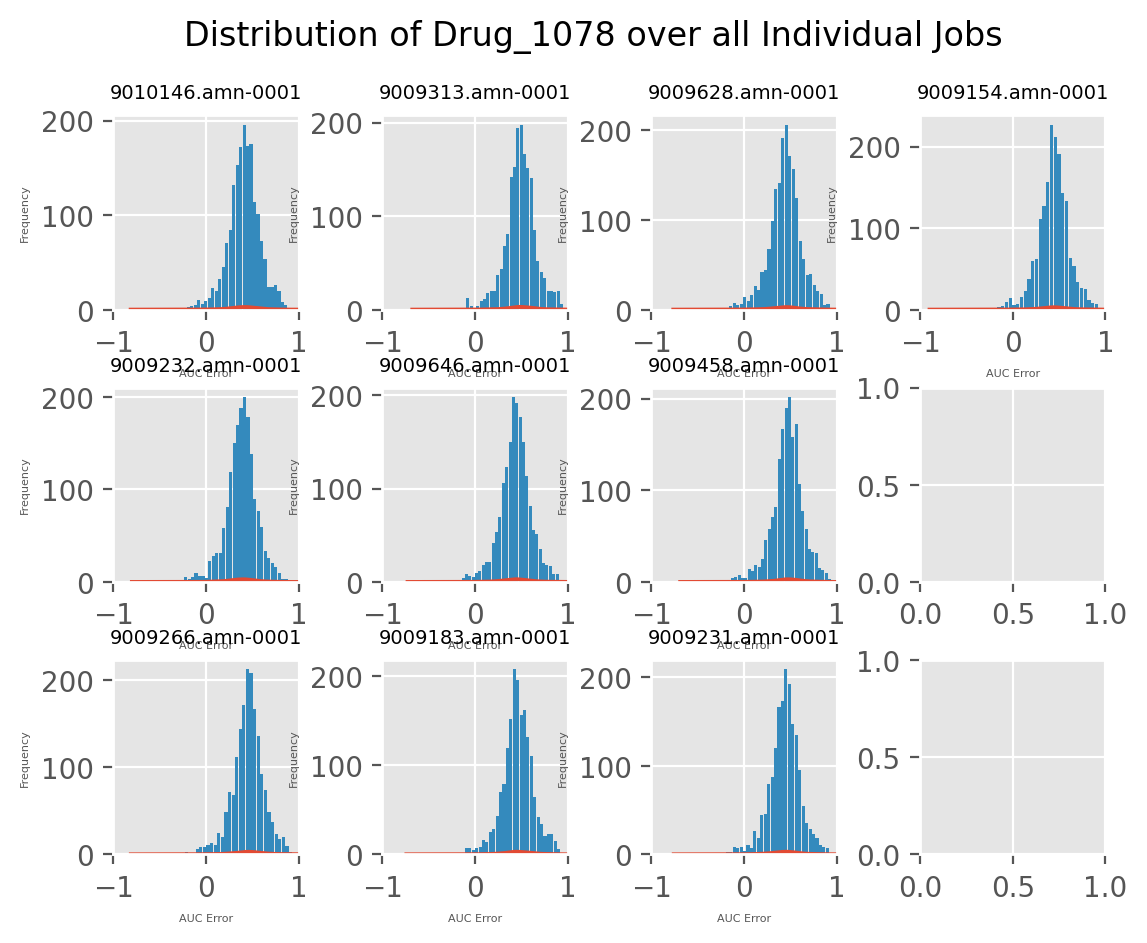

In [178]:
make_multiplot("Drug_1078", path=path, wanted_jobs=os.listdir(path))

In [179]:
boot_1078 = boostraped_rmse(drug_dict["Drug_1078"], 100000)

100%|██████████| 100000/100000 [00:38<00:00, 2584.07it/s]


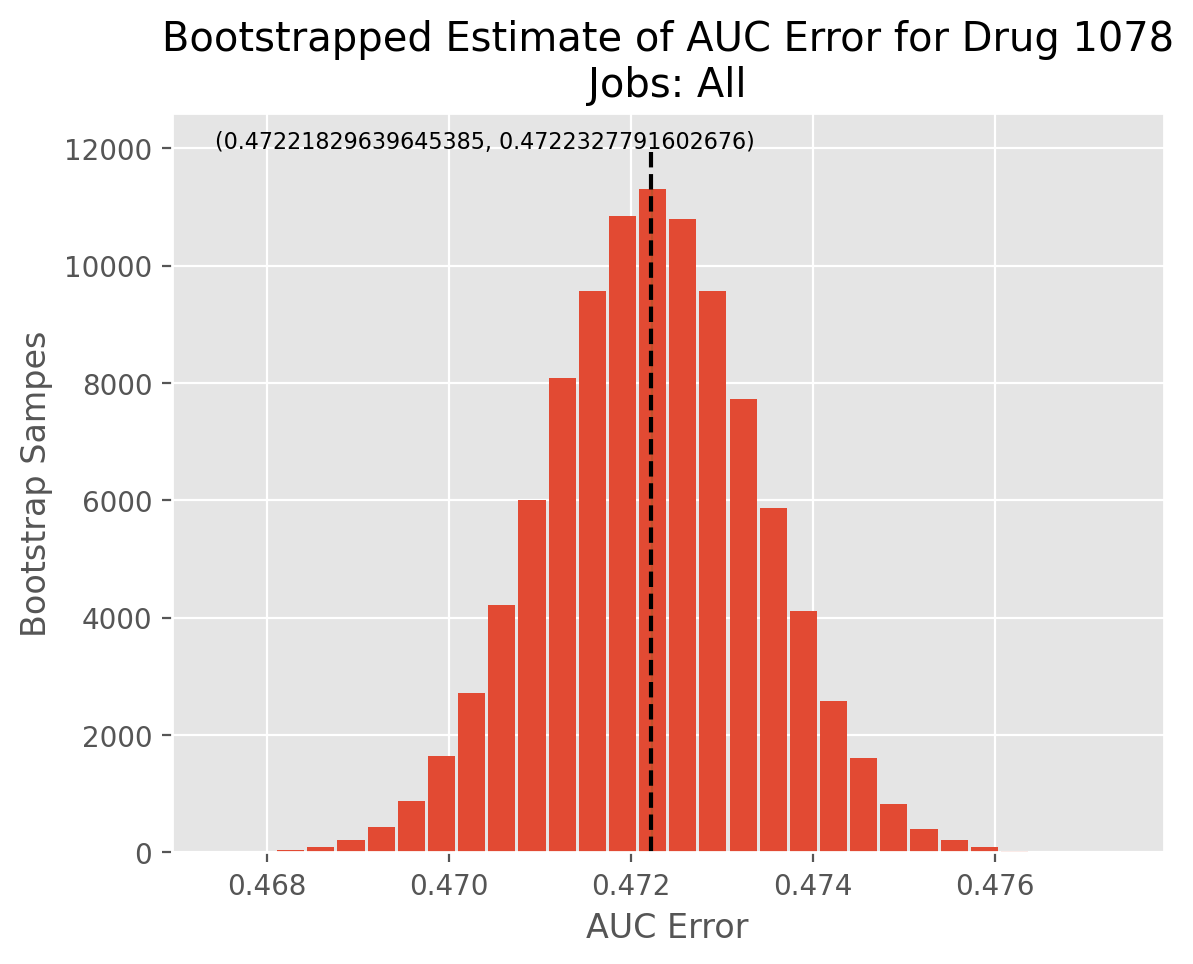

In [180]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_1078)-1, 
                        loc = np.mean(boot_1078), 
                        scale = st.sem(boot_1078) )

heights, bins, patches = ax.hist(boot_1078, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(boot_1078), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 1078\nJobs: All")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(boot_1078), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

In [181]:
dfs_ALL = []

for val in drug_dict.values():
    dfs_ALL.append(val)
    
df = pd.concat(dfs_ALL)

In [182]:
df

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.9901,ACH-000002,Drug_618,0.6198,-0.370300
1,0.9577,ACH-000005,Drug_618,0.5463,-0.411400
2,0.9923,ACH-000008,Drug_618,0.6922,-0.300100
3,0.9221,ACH-000009,Drug_618,0.6542,-0.267900
4,0.9638,ACH-000014,Drug_618,0.6835,-0.280300
...,...,...,...,...,...
643,0.8888,ACH-001075,Drug_752,0.9015,0.012720
644,0.8913,ACH-001239,Drug_752,0.9007,0.009370
645,0.8497,ACH-001306,Drug_752,0.9347,0.084970
646,0.9356,ACH-001307,Drug_752,0.9287,-0.006936


In [183]:
csv = pairwise_tukeyhsd(df["AUCError"], df["Drug1"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)
turkey_df["  group1 "] = turkey_df["  group1 "].str.strip()
turkey_df["  group2 "] = turkey_df["  group2 "].str.strip()

In [184]:
print(turkey_df[turkey_df["  group1 "] == "Drug_1078"].to_string())
# print(turkey_df["  group1 "])
# print(turkey_df.to_string())


         group1     group2   meandiff  p-adj    lower    upper   reject
10644  Drug_1078  Drug_1082   -0.2731     0.0  -0.2793  -0.2669  True  
10645  Drug_1078  Drug_1085   -0.4992     0.0  -0.5060  -0.4924  True  
10646  Drug_1078  Drug_1086   -0.5733     0.0  -0.5809  -0.5658  True  
10647  Drug_1078  Drug_1096   -0.3842     0.0  -0.3908  -0.3775  True  
10648  Drug_1078  Drug_1097   -0.4468     0.0  -0.4533  -0.4403  True  
10649  Drug_1078  Drug_1098   -0.4561     0.0  -0.4667  -0.4455  True  
10650  Drug_1078  Drug_1099   -0.4453     0.0  -0.4558  -0.4348  True  
10651  Drug_1078  Drug_1100   -0.4413     0.0  -0.4475  -0.4350  True  
10652  Drug_1078  Drug_1101   -0.4285     0.0  -0.4392  -0.4179  True  
10653  Drug_1078  Drug_1110   -0.4227     0.0  -0.4273  -0.4182  True  
10654  Drug_1078  Drug_1116   -0.3935     0.0  -0.3987  -0.3884  True  
10655  Drug_1078  Drug_1117   -0.2685     0.0  -0.2747  -0.2622  True  
10656  Drug_1078  Drug_1122   -0.3017     0.0  -0.3086  -0.2947 

In [185]:
jobs_75 = ['8997987.amn-0001', '8999189.amn-0001', '8998722.amn-0001','8999163.amn-0001']
dict_75 =get_data_ALL(path=path1, wanted_jobs=jobs_75)


100%|██████████| 144/144 [00:00<00:00, 3382.18it/s]


In [191]:
dict_75["Drug_988"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [192]:
dfs_ALL_75 = []

for val in dict_75.values():
    dfs_ALL_75.append(val)
    
df_75 = pd.concat(dfs_ALL_75)
df_75[df_75["Drug1"] == "Drug_988"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [193]:
big_df = pd.concat([df, df_75])
big_df[big_df["Drug1"] == "Drug_988"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3989,0.10860
1,0.2636,ACH-000002,Drug_988,0.3680,0.10440
2,0.2858,ACH-000002,Drug_988,0.3475,0.06174
3,0.2929,ACH-000002,Drug_988,0.3611,0.06815
4,0.3114,ACH-000002,Drug_988,0.3865,0.07509
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9416,0.58380
1897,0.4194,ACH-001307,Drug_988,0.8959,0.47650
1898,0.3146,ACH-001318,Drug_988,0.9335,0.61890
1899,0.6505,ACH-001318,Drug_988,0.9279,0.27740


In [194]:
csv = pairwise_tukeyhsd(big_df["AUCError"], big_df["Drug1"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)
turkey_df["  group1 "] = turkey_df["  group1 "].str.strip()
turkey_df["  group2 "] = turkey_df["  group2 "].str.strip()

In [202]:
print(turkey_df[turkey_df["  group2 "] == "Drug_1078"].to_string())

         group1     group2   meandiff  p-adj    lower    upper   reject
28       Drug_10  Drug_1078    0.4486     0.0   0.4413   0.4558  True  
626    Drug_1005  Drug_1078    0.3802     0.0   0.3743   0.3861  True  
1223    Drug_101  Drug_1078    0.4800     0.0   0.4725   0.4876  True  
1819   Drug_1010  Drug_1078    0.4418     0.0   0.4352   0.4485  True  
2414   Drug_1012  Drug_1078    0.4590     0.0   0.4525   0.4656  True  
3008   Drug_1015  Drug_1078    0.4611     0.0   0.4507   0.4714  True  
3601   Drug_1016  Drug_1078    0.4004     0.0   0.3938   0.4070  True  
4193   Drug_1021  Drug_1078    0.4466     0.0   0.4401   0.4532  True  
4784   Drug_1022  Drug_1078    0.5539     0.0   0.5467   0.5610  True  
5374   Drug_1026  Drug_1078    0.4436     0.0   0.4325   0.4547  True  
5963   Drug_1028  Drug_1078    0.4562     0.0   0.4495   0.4629  True  
6551   Drug_1030  Drug_1078    0.2131     0.0   0.2067   0.2195  True  
7138   Drug_1032  Drug_1078    0.2327     0.0   0.2239   0.2414 